In [69]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics as tm
import numpy as np
import pandas as pd
from snowflake.snowpark import Session
import darts
import json
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm.autonotebook import tqdm
import seaborn as sns


import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, TFTModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
credentials = json.load(open('secrets.json'))["SNOWFLAKE_CONNECTION"]
session = Session.builder.configs(credentials).create()
session.use_database("hackathon")
session.use_schema("public")
mdf = session.table("challenge1_train_data")
mdf = mdf.to_pandas()
mdf.columns = mdf.columns.str.lower()
mdf["date"] = pd.to_datetime(mdf["date"])
mdf.head()

,date,dc_name,size_code,retail_price,total_tires,zip_code
0,2022-02-05,OAKLAND,1856015,70.090,1,94604
1,2021-03-02,OAKLAND,1856015,59.090,1,94604
2,2020-12-08,OAKLAND,1856015,53.545,1,94604
3,2022-01-17,OAKLAND,1856015,58.410,1,94604
4,2020-11-13,OAKLAND,1856015,43.085,1,94604


In [3]:
mdf["month"] = mdf["date"].dt.month
mdf["year"] = mdf["date"].dt.year
mdf["quarter"] = mdf["date"].dt.quarter
mdf["weekday"] = mdf["date"].dt.weekday
mdf

,date,dc_name,size_code,retail_price,total_tires,zip_code,month,year,quarter,weekday
0,2022-02-05,OAKLAND,1856015,70.090,1,94604,2,2022,1,5
1,2021-03-02,OAKLAND,1856015,59.090,1,94604,3,2021,1,1
2,2020-12-08,OAKLAND,1856015,53.545,1,94604,12,2020,4,1
3,2022-01-17,OAKLAND,1856015,58.410,1,94604,1,2022,1,0
4,2020-11-13,OAKLAND,1856015,43.085,1,94604,11,2020,4,4
...,...,...,...,...,...,...,...,...,...,...
284695,2022-07-24,BAKERSFIELD,3512520,0.000,0,93308,7,2022,3,6
284696,2020-11-22,BAKERSFIELD,3512520,0.000,0,93308,11,2020,4,6
284697,2021-08-08,BAKERSFIELD,3512520,0.000,0,93308,8,2021,3,6
284698,2022-02-14,BAKERSFIELD,3512520,0.000,0,93308,2,2022,1,0


<AxesSubplot:xlabel='month'>

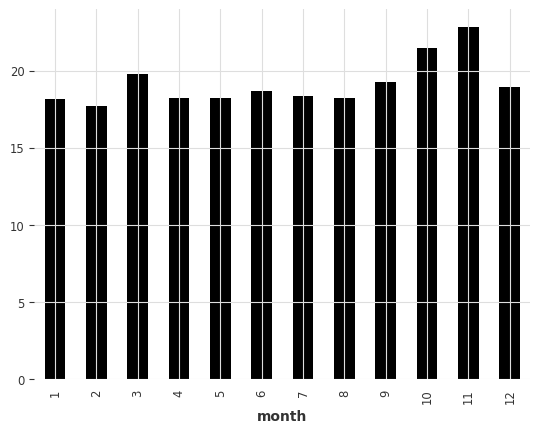

In [4]:
mdf.groupby("month")["total_tires"].mean().plot.bar()

<AxesSubplot:xlabel='weekday'>

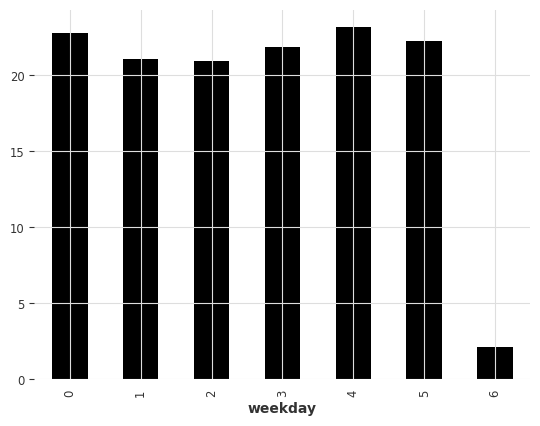

In [9]:
mdf.groupby("weekday")["total_tires"].mean().plot.bar()

In [5]:
dfs = {name: frame for name, frame in mdf.groupby(["dc_name", "size_code"])}
dfs

{('BAKERSFIELD',
  1856015):              date      dc_name  size_code  retail_price  total_tires  \
 173740 2021-04-07  BAKERSFIELD    1856015        77.240            1   
 173741 2021-04-10  BAKERSFIELD    1856015        55.090            1   
 173742 2022-01-28  BAKERSFIELD    1856015         6.455            1   
 173743 2022-01-18  BAKERSFIELD    1856015        91.090            1   
 173744 2021-02-19  BAKERSFIELD    1856015        56.045            1   
 ...           ...          ...        ...           ...          ...   
 271160 2022-09-06  BAKERSFIELD    1856015         0.000            0   
 271161 2021-08-15  BAKERSFIELD    1856015         0.000            0   
 271162 2021-09-06  BAKERSFIELD    1856015         0.000            0   
 271163 2020-11-08  BAKERSFIELD    1856015         0.000            0   
 271164 2021-01-01  BAKERSFIELD    1856015         0.000            0   
 
         zip_code  month  year  quarter  weekday  
 173740     93308      4  2021        2    

<AxesSubplot:xlabel='date'>

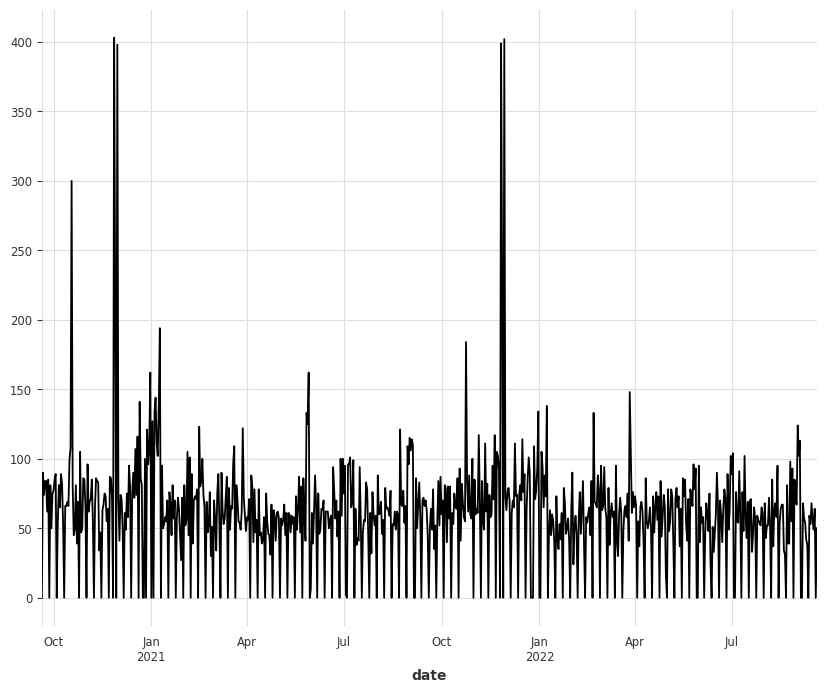

In [6]:
df = dfs[('BAKERSFIELD', 2155517)]
df.groupby("date")["total_tires"].sum().plot.line(figsize=(10, 8))

In [7]:
df["date"].max()

Timestamp('2022-09-19 00:00:00')

In [8]:
for (dc, code), df in dfs.items():
    dc = dc.lower().replace(" ", "_")
    new_col = f"total_tires_{dc}_{code}"
    mdf[new_col] = df["total_tires"]
    
mdf.columns

Index(['date', 'dc_name', 'size_code', 'retail_price', 'total_tires',
       'zip_code', 'month', 'year', 'quarter', 'weekday',
       ...
       'total_tires_san_jose_2657516', 'total_tires_san_jose_2755520',
       'total_tires_san_jose_2756020', 'total_tires_san_jose_2756518',
       'total_tires_san_jose_2756520', 'total_tires_san_jose_2757018',
       'total_tires_san_jose_2854522', 'total_tires_san_jose_2857017',
       'total_tires_san_jose_3512520', 'total_tires_san_jose_22570195'],
      dtype='object', length=400)

In [27]:
targets = mdf.filter(like=r"total_tires_").columns
targets

Index(['total_tires_bakersfield_1856015', 'total_tires_bakersfield_1856514',
       'total_tires_bakersfield_1856515', 'total_tires_bakersfield_1956015',
       'total_tires_bakersfield_1956515', 'total_tires_bakersfield_2055016',
       'total_tires_bakersfield_2055017', 'total_tires_bakersfield_2055516',
       'total_tires_bakersfield_2056016', 'total_tires_bakersfield_2056515',
       ...
       'total_tires_san_jose_2657516', 'total_tires_san_jose_2755520',
       'total_tires_san_jose_2756020', 'total_tires_san_jose_2756518',
       'total_tires_san_jose_2756520', 'total_tires_san_jose_2757018',
       'total_tires_san_jose_2854522', 'total_tires_san_jose_2857017',
       'total_tires_san_jose_3512520', 'total_tires_san_jose_22570195'],
      dtype='object', length=390)

In [32]:
mdf2 = mdf.groupby("date")[targets].mean()
mdf2

,total_tires_bakersfield_1856015,total_tires_bakersfield_1856514,total_tires_bakersfield_1856515,total_tires_bakersfield_1956015,total_tires_bakersfield_1956515,total_tires_bakersfield_2055016,total_tires_bakersfield_2055017,total_tires_bakersfield_2055516,total_tires_bakersfield_2056016,total_tires_bakersfield_2056515,...,total_tires_san_jose_2657516,total_tires_san_jose_2755520,total_tires_san_jose_2756020,total_tires_san_jose_2756518,total_tires_san_jose_2756520,total_tires_san_jose_2757018,total_tires_san_jose_2854522,total_tires_san_jose_2857017,total_tires_san_jose_3512520,total_tires_san_jose_22570195
date,,,,,,,,,,,,,,,,,,,,,
2020-09-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,4.0,2.0,0.0,4.0,0.0,2.0,0.0,6.0,0.0
2020-09-21,18.0,11.0,32.0,35.0,61.0,3.0,4.0,129.0,37.0,21.0,...,6.0,36.0,8.0,20.0,12.0,17.0,9.0,6.0,7.0,7.0
2020-09-22,7.0,3.0,4.0,46.0,19.0,18.0,10.0,82.0,37.0,10.0,...,7.0,35.0,4.0,13.0,8.0,15.0,7.0,12.0,37.0,9.0
2020-09-23,3.0,2.0,9.0,37.0,29.0,8.0,5.0,92.0,28.0,28.0,...,3.0,38.0,24.0,9.0,6.0,12.0,4.0,6.0,29.0,8.0
2020-09-24,15.0,8.0,12.0,38.0,54.0,8.0,12.0,86.0,38.0,16.0,...,12.0,21.0,11.0,10.0,2.0,10.0,11.0,6.0,20.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-15,5.0,9.0,2.0,28.0,23.0,2.0,13.0,94.0,41.0,10.0,...,6.0,8.0,11.0,6.0,14.0,1.0,9.0,0.0,8.0,1.0
2022-09-16,3.0,4.0,11.0,18.0,10.0,7.0,7.0,64.0,27.0,5.0,...,6.0,26.0,22.0,2.0,0.0,29.0,2.0,0.0,10.0,17.0
2022-09-17,3.0,4.0,16.0,23.0,37.0,6.0,17.0,69.0,33.0,13.0,...,1.0,6.0,4.0,0.0,0.0,8.0,0.0,5.0,0.0,0.0


In [33]:
# Read data:
series = TimeSeries.from_dataframe(mdf2.reset_index(),
                                   time_col="date",
                                   value_cols=mdf2.filter(like="total_tires_").columns,
                                   freq="D",
                                   fill_missing_dates=True)

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp("20220801"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
# Change name
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)
train_scaled

<TimeSeries (DataArray) (date: 681, component: 390, sample: 1)>
array([[[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.10909091],
        [0.        ]],

       [[0.32727273],
        [0.2972973 ],
        [0.28070175],
        ...,
        [0.2       ],
        [0.12727273],
        [0.11290323]],

       [[0.12727273],
        [0.08108108],
        [0.03508772],
        ...,
...
        ...,
        [0.        ],
        [0.23636364],
        [0.12903226]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.27272727],
        [0.02702703],
        [0.12280702],
        ...,
        [0.        ],
        [0.10909091],
        [0.09677419]]])
Coordinates:
  * date       (date) datetime64[ns] 2020-09-20 2020-09-21 ... 2022-08-01
  * component  (component) object 'total_tires_bakersfield_1856015' ... 'tota...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [58]:
model = TransformerModel(
    pl_trainer_kwargs={"accelerator": "gpu", "devices":[0]},
    input_chunk_length=31,
    output_chunk_length=18,
    batch_size=32,
    n_epochs=200,
    model_name="tire_transformer",
    nr_epochs_val_period=10,
    d_model=32,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=512,
    dropout=0.1,
    torch_metrics=tm.WeightedMeanAbsolutePercentageError(),
    activation="relu",
    random_state=155,
    save_checkpoints=True,
    force_reset=True,
)

model

In [59]:
model.fit(series=train_scaled, val_series=val_scaled, verbose=True)

Epoch 9:  95%|▉| 20/21 [00:00<00:00, 47.45it/s, loss=0.0274, train_loss=0.0276, train_WeightedMeanAbsolutePercentageErr
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/1 [00:00<?, ?it/s]
Epoch 9: 100%|█| 21/21 [00:00<00:00, 48.22it/s, loss=0.0274, train_loss=0.0276, train_WeightedMeanAbsolutePercentageErr
Epoch 19:  95%|▉| 20/21 [00:00<00:00, 50.98it/s, loss=0.0267, train_loss=0.0281, train_WeightedMeanAbsolutePercentageEr
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/1 [00:00<?, ?it/s]
Epoch 19: 100%|█| 21/21 [00:00<00:00, 51.82it/s, loss=0.0267, train_loss=0.0281, train_WeightedMeanAbsolutePercentageEr
Epoch 29:  95%|▉| 20/21 [00:00<00:00, 49.09it/s, loss=0.0265, train_loss=0.0285, train_WeightedMeanAbsolutePercentageEr
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                     

Validation DataLoader 0:   0%|                                                                   | 0/1 [00:00<?, ?it/s]
Epoch 159: 100%|█| 21/21 [00:00<00:00, 48.18it/s, loss=0.0215, train_loss=0.0199, train_WeightedMeanAbsolutePercentageE
Epoch 169:  95%|▉| 20/21 [00:00<00:00, 54.41it/s, loss=0.0206, train_loss=0.0212, train_WeightedMeanAbsolutePercentageE
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/1 [00:00<?, ?it/s]
Epoch 169: 100%|█| 21/21 [00:00<00:00, 55.33it/s, loss=0.0206, train_loss=0.0212, train_WeightedMeanAbsolutePercentageE
Epoch 179:  95%|▉| 20/21 [00:00<00:00, 55.70it/s, loss=0.0196, train_loss=0.0189, train_WeightedMeanAbsolutePercentageE
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/1 [00:00<?, ?it/s]
Epoch 179: 100%|█| 21/21 [00:00<00:00, 56.82it/s, loss=0.0196, train_loss=0.0189, train_WeightedMe

In [51]:
def simple_wape(y_true, y_pred):
    """Calculates simple wape"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.round(
        abs(y_true - y_pred).sum() / abs(y_true).sum()
        if abs(y_true).sum() != 0
        else np.inf,
        5,
    )

Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 54.05it/s]
tensor(0.0843)


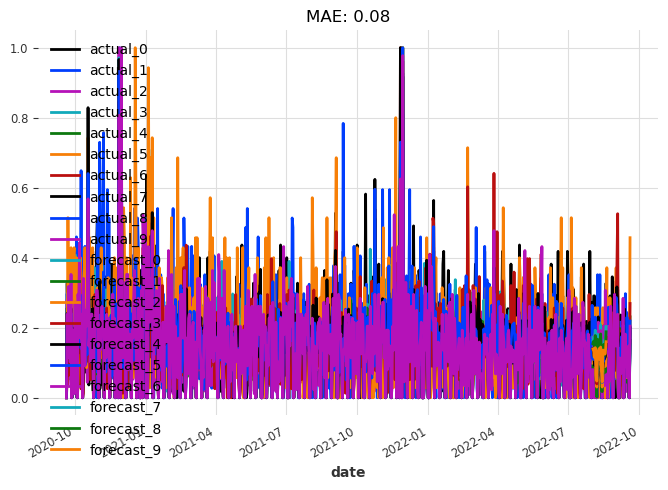

In [79]:
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
#     fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 30))
    plt.figure(figsize=(8, 5))
#     series, pred_series, val_series = series.values(), pred_series.values(), val_series.values()

#     sns.lineplot(x=pred_series[:, 0], ax=ax1)
    series.plot(label="actual")
    pred_series.plot(label="forecast")
    cut = min(len(pred_series), len(val_series))
    pred_series = pred_series[:cut]
    val_series = val_series[:cut]
#     wape = simple_wape(pred_series.univariate_values(), val_series.univariate_values())
    metric = tm.MMeanAbsoluteError()
#     metric = tm.WeightedMeanAbsolutePercentageError()
    score = metric(torch.tensor(pred_series.values()), torch.tensor(val_series.values()))
    print(score)
    plt.title(f"MAE: {score:.2f}")
#     plt.title("WAPE: {:.2f}%".format(wape * 100))
    plt.legend()
    plt.show()
    
eval_model(model, 18, series_scaled, val_scaled)

In [82]:
mdf.sample(35)

,date,dc_name,size_code,retail_price,total_tires,zip_code,month,year,quarter,weekday,...,total_tires_san_jose_2657516,total_tires_san_jose_2755520,total_tires_san_jose_2756020,total_tires_san_jose_2756518,total_tires_san_jose_2756520,total_tires_san_jose_2757018,total_tires_san_jose_2854522,total_tires_san_jose_2857017,total_tires_san_jose_3512520,total_tires_san_jose_22570195
265047,2022-04-03,SACRAMENTO,2457517,0.000,0,95838,4,2022,2,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193190,2022-05-02,BAKERSFIELD,2255517,124.275,111,93308,5,2022,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128251,2020-11-11,SACRAMENTO,2356518,132.120,31,95838,11,2020,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27760,2020-11-19,OAKLAND,2355520,173.090,10,94604,11,2020,4,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253516,2021-05-16,SAN JOSE,2555020,0.000,0,95131,5,2021,2,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273040,2021-11-14,BAKERSFIELD,2154517,0.000,0,93308,11,2021,4,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40405,2022-04-11,OAKLAND,2556019,190.455,3,94604,4,2022,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134008,2022-03-24,SACRAMENTO,2454018,155.240,37,95838,3,2022,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45679,2021-10-19,OAKLAND,2756020,184.530,11,94604,10,2021,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224104,2021-04-22,BAKERSFIELD,2555520,145.950,22,93308,4,2021,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 100.00it/s]
tensor(0.0908)


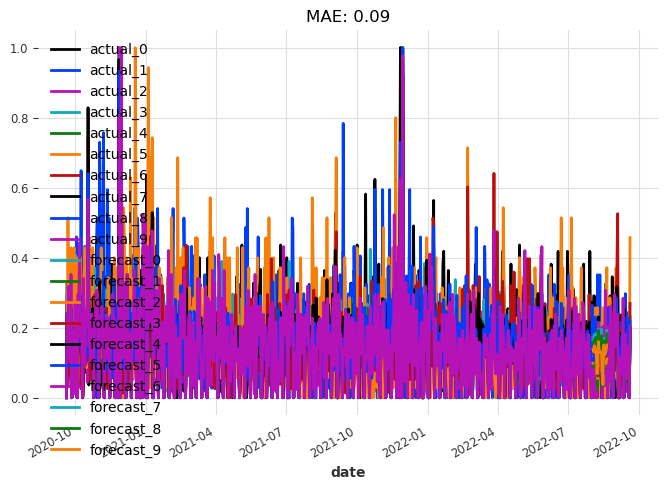

In [80]:
best_model = TransformerModel.load_from_checkpoint(
    model_name="tire_transformer", best=True
)
eval_model(best_model, 19, series_scaled, val_scaled)